In [1]:
!pip install --upgrade pip
!pip install datasets accelerate transformers tqdm torch torchvision torchaudio requests "urllib3<2" scikit-learn matplotlib
!pip install -U accelerate
!pip install -U transformers

Looking in indexes: https://pypi.org/simple, https://pypi.idi.ntnu.no
Looking in indexes: https://pypi.org/simple, https://pypi.idi.ntnu.no
Looking in indexes: https://pypi.org/simple, https://pypi.idi.ntnu.no
Looking in indexes: https://pypi.org/simple, https://pypi.idi.ntnu.no


In [2]:
from transformers import TrainingArguments, AutoImageProcessor, ResNetForImageClassification, ResNetConfig, Trainer
import torch
import numpy as np
from datasets import load_dataset

/home/tommydl/TDT05-Project-23/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
x = torch.ones(1).to(device)
print(x)

tensor([1.], device='cuda:0')


In [4]:
def load_data():
    d_types = ['train'] # 60k images
    datasets = []
    for d in d_types:
        datasets.append(load_dataset(
            'mnist',
            split=d,
        ))
    return datasets


dataset = load_data()[0].map(lambda x: {'image': torch.tensor(np.repeat(np.array(x['image'])[:, :, np.newaxis], 3, axis=2)), 'label': x['label']})



In [5]:
# 98% for validation, 1% for test and 1% for training
split = dataset.train_test_split(test_size=0.98)
temp_split = split['train'].train_test_split(test_size=1/2)
dataset_train = temp_split['train']
dataset_test = temp_split['test']
dataset_valid = split['test']
dataset_train, dataset_test, dataset_valid

(Dataset({
     features: ['image', 'label'],
     num_rows: 600
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 600
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 58800
 }))

In [6]:
# check how many labels/number of classes
num_classes = len(set(dataset_train['label']))
labels = dataset_train.features['label'].names
num_classes, labels

(10, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [7]:
dataset_train['image'][1].size

(28, 28)

In [8]:
# import feature extraction model
model_id = 'microsoft/resnet-152'

feature_extractor = AutoImageProcessor.from_pretrained(
    model_id
)
config = ResNetConfig()
config.num_labels = num_classes
model = ResNetForImageClassification(config)
model = model.from_pretrained(
    model_id,  # classification head
).train().to(device)

model.num_parameters()

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


60192808

In [9]:
def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor(
        batch['image'],
        return_tensors='pt'
    )
    # include the labels
    inputs['labels'] = batch['label']
    return inputs

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

# transform the training dataset
prepared_train = dataset_train.with_transform(preprocess)
# ... and the testing dataset
prepared_test = dataset_test.with_transform(preprocess)
# ... and the validation dataset
prepared_valid = dataset_valid.with_transform(preprocess)



In [10]:
import numpy as np
from datasets import load_metric

# accuracy metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )


/tmp/ipykernel_49355/1389652664.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [11]:
from transformers import Trainer

eval_save_step = 50

# training the model
training_args = TrainingArguments(
  output_dir="./cnn_model",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=10,
  save_steps=eval_save_step,
  eval_steps=eval_save_step,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  optim='adamw_torch',
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

train_results = trainer.train(resume_from_checkpoint=False)
# save tokenizer with the model
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()

  3%|▎         | 11/380 [00:07<01:19,  4.63it/s]

{'loss': 6.6353, 'learning_rate': 0.00019473684210526317, 'epoch': 0.26}


  6%|▌         | 21/380 [00:09<01:01,  5.87it/s]

{'loss': 5.0087, 'learning_rate': 0.00018947368421052632, 'epoch': 0.53}


  8%|▊         | 31/380 [00:11<00:59,  5.83it/s]

{'loss': 2.9086, 'learning_rate': 0.00018421052631578948, 'epoch': 0.79}


 11%|█         | 41/380 [00:12<01:00,  5.61it/s]

{'loss': 1.8945, 'learning_rate': 0.00017894736842105264, 'epoch': 1.05}


 13%|█▎        | 50/380 [00:14<00:54,  6.06it/s]

{'loss': 1.2042, 'learning_rate': 0.0001736842105263158, 'epoch': 1.32}


                                                
 13%|█▎        | 50/380 [00:18<00:54,  6.06it/s]

{'eval_loss': 1.910155177116394, 'eval_accuracy': 0.45, 'eval_runtime': 4.3584, 'eval_samples_per_second': 137.666, 'eval_steps_per_second': 17.208, 'epoch': 1.32}


 16%|█▌        | 61/380 [00:21<01:01,  5.15it/s]

{'loss': 0.7615, 'learning_rate': 0.00016842105263157895, 'epoch': 1.58}


 19%|█▊        | 71/380 [00:22<00:46,  6.71it/s]

{'loss': 0.7714, 'learning_rate': 0.0001631578947368421, 'epoch': 1.84}


 21%|██▏       | 81/380 [00:24<00:47,  6.27it/s]

{'loss': 0.5243, 'learning_rate': 0.00015789473684210527, 'epoch': 2.11}


 24%|██▍       | 91/380 [00:26<00:49,  5.82it/s]

{'loss': 0.3164, 'learning_rate': 0.00015263157894736845, 'epoch': 2.37}


 26%|██▋       | 100/380 [00:27<00:40,  6.96it/s]

{'loss': 0.368, 'learning_rate': 0.00014736842105263158, 'epoch': 2.63}


                                                 
 26%|██▋       | 100/380 [00:31<00:40,  6.96it/s]

{'eval_loss': 0.5859881043434143, 'eval_accuracy': 0.8166666666666667, 'eval_runtime': 4.0951, 'eval_samples_per_second': 146.516, 'eval_steps_per_second': 18.314, 'epoch': 2.63}


 29%|██▉       | 111/380 [00:34<00:50,  5.31it/s]

{'loss': 0.4417, 'learning_rate': 0.00014210526315789474, 'epoch': 2.89}


 32%|███▏      | 121/380 [00:35<00:36,  7.00it/s]

{'loss': 0.2496, 'learning_rate': 0.0001368421052631579, 'epoch': 3.16}


 34%|███▍      | 131/380 [00:36<00:34,  7.21it/s]

{'loss': 0.3112, 'learning_rate': 0.00013157894736842108, 'epoch': 3.42}


 37%|███▋      | 141/380 [00:38<00:33,  7.07it/s]

{'loss': 0.1473, 'learning_rate': 0.0001263157894736842, 'epoch': 3.68}


 39%|███▉      | 150/380 [00:39<00:34,  6.74it/s]

{'loss': 0.1927, 'learning_rate': 0.00012105263157894738, 'epoch': 3.95}


                                                 
 39%|███▉      | 150/380 [00:43<00:34,  6.74it/s]

{'eval_loss': 0.2750692367553711, 'eval_accuracy': 0.9116666666666666, 'eval_runtime': 3.8966, 'eval_samples_per_second': 153.98, 'eval_steps_per_second': 19.248, 'epoch': 3.95}


 42%|████▏     | 161/380 [00:46<00:43,  5.07it/s]

{'loss': 0.2286, 'learning_rate': 0.00011578947368421053, 'epoch': 4.21}


 45%|████▌     | 171/380 [00:47<00:33,  6.26it/s]

{'loss': 0.0684, 'learning_rate': 0.0001105263157894737, 'epoch': 4.47}


 48%|████▊     | 181/380 [00:49<00:29,  6.82it/s]

{'loss': 0.0562, 'learning_rate': 0.00010526315789473685, 'epoch': 4.74}


 50%|█████     | 190/380 [00:50<00:28,  6.56it/s]

{'loss': 0.119, 'learning_rate': 0.0001, 'epoch': 5.0}


 53%|█████▎    | 200/380 [00:52<00:29,  6.13it/s]

{'loss': 0.0538, 'learning_rate': 9.473684210526316e-05, 'epoch': 5.26}


                                                 
 53%|█████▎    | 200/380 [00:56<00:29,  6.13it/s]

{'eval_loss': 0.3490610718727112, 'eval_accuracy': 0.925, 'eval_runtime': 4.0258, 'eval_samples_per_second': 149.04, 'eval_steps_per_second': 18.63, 'epoch': 5.26}


 56%|█████▌    | 211/380 [00:58<00:30,  5.46it/s]

{'loss': 0.0747, 'learning_rate': 8.947368421052632e-05, 'epoch': 5.53}


 58%|█████▊    | 221/380 [01:00<00:23,  6.87it/s]

{'loss': 0.0783, 'learning_rate': 8.421052631578948e-05, 'epoch': 5.79}


 61%|██████    | 231/380 [01:01<00:20,  7.26it/s]

{'loss': 0.0499, 'learning_rate': 7.894736842105263e-05, 'epoch': 6.05}


 63%|██████▎   | 241/380 [01:02<00:19,  7.04it/s]

{'loss': 0.058, 'learning_rate': 7.368421052631579e-05, 'epoch': 6.32}


 66%|██████▌   | 250/380 [01:04<00:18,  6.94it/s]

{'loss': 0.0118, 'learning_rate': 6.842105263157895e-05, 'epoch': 6.58}


                                                 
 66%|██████▌   | 250/380 [01:08<00:18,  6.94it/s]

{'eval_loss': 0.19018025696277618, 'eval_accuracy': 0.955, 'eval_runtime': 4.0193, 'eval_samples_per_second': 149.278, 'eval_steps_per_second': 18.66, 'epoch': 6.58}


 69%|██████▊   | 261/380 [01:10<00:22,  5.39it/s]

{'loss': 0.1769, 'learning_rate': 6.31578947368421e-05, 'epoch': 6.84}


 71%|███████▏  | 271/380 [01:12<00:17,  6.06it/s]

{'loss': 0.0518, 'learning_rate': 5.789473684210527e-05, 'epoch': 7.11}


 74%|███████▍  | 281/380 [01:13<00:16,  6.09it/s]

{'loss': 0.0391, 'learning_rate': 5.2631578947368424e-05, 'epoch': 7.37}


 77%|███████▋  | 291/380 [01:15<00:14,  6.18it/s]

{'loss': 0.0912, 'learning_rate': 4.736842105263158e-05, 'epoch': 7.63}


 79%|███████▉  | 300/380 [01:16<00:11,  6.86it/s]

{'loss': 0.0197, 'learning_rate': 4.210526315789474e-05, 'epoch': 7.89}


                                                 
 79%|███████▉  | 300/380 [01:20<00:11,  6.86it/s]

{'eval_loss': 0.1270710974931717, 'eval_accuracy': 0.9716666666666667, 'eval_runtime': 4.0433, 'eval_samples_per_second': 148.393, 'eval_steps_per_second': 18.549, 'epoch': 7.89}


 82%|████████▏ | 311/380 [01:23<00:14,  4.85it/s]

{'loss': 0.0072, 'learning_rate': 3.6842105263157895e-05, 'epoch': 8.16}


 84%|████████▍ | 321/380 [01:25<00:10,  5.70it/s]

{'loss': 0.0251, 'learning_rate': 3.157894736842105e-05, 'epoch': 8.42}


 87%|████████▋ | 331/380 [01:26<00:07,  6.85it/s]

{'loss': 0.068, 'learning_rate': 2.6315789473684212e-05, 'epoch': 8.68}


 90%|████████▉ | 341/380 [01:28<00:06,  6.35it/s]

{'loss': 0.0017, 'learning_rate': 2.105263157894737e-05, 'epoch': 8.95}


 92%|█████████▏| 350/380 [01:29<00:05,  5.55it/s]

{'loss': 0.0053, 'learning_rate': 1.5789473684210526e-05, 'epoch': 9.21}


                                                 
 92%|█████████▏| 350/380 [01:34<00:05,  5.55it/s]

{'eval_loss': 0.1399812251329422, 'eval_accuracy': 0.9716666666666667, 'eval_runtime': 4.4408, 'eval_samples_per_second': 135.11, 'eval_steps_per_second': 16.889, 'epoch': 9.21}


 95%|█████████▌| 361/380 [01:36<00:03,  5.35it/s]

{'loss': 0.0053, 'learning_rate': 1.0526315789473684e-05, 'epoch': 9.47}


 98%|█████████▊| 371/380 [01:38<00:01,  6.42it/s]

{'loss': 0.0051, 'learning_rate': 5.263157894736842e-06, 'epoch': 9.74}


{'loss': 0.0148, 'learning_rate': 0.0, 'epoch': 10.0}
{'train_runtime': 99.5406, 'train_samples_per_second': 60.277, 'train_steps_per_second': 3.818, 'train_loss': 0.606455829798391, 'epoch': 10.0}


100%|██████████| 380/380 [01:39<00:00,  3.82it/s]


***** train metrics *****
  epoch                    =       10.0
  train_loss               =     0.6065
  train_runtime            = 0:01:39.54
  train_samples_per_second =     60.277
  train_steps_per_second   =      3.818


In [12]:
# evaluate with valid
metrics = trainer.evaluate(prepared_valid)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


100%|██████████| 7350/7350 [06:39<00:00, 18.38it/s]

***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.9637
  eval_loss               =      0.166
  eval_runtime            = 0:06:40.03
  eval_samples_per_second =    146.987
  eval_steps_per_second   =     18.373


Text(0.5, 1.0, 'ResNet: Loss over train steps')

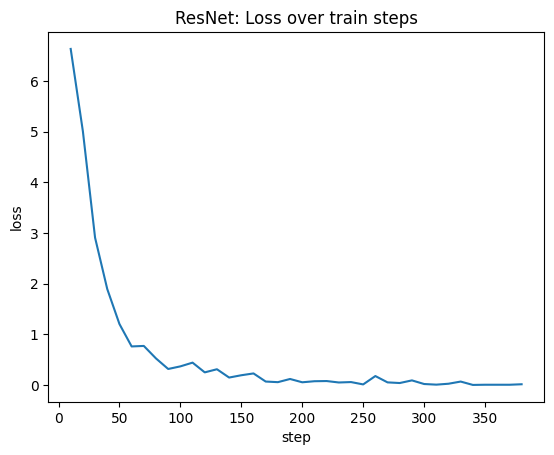

In [13]:
from matplotlib import pyplot as plt

x = [log['step'] for log in trainer.state.log_history if 'loss' in log]
y = [log['loss'] for log in trainer.state.log_history if 'loss' in log]


# y axis is loss
# x axis is step
plt.plot(x, y)
plt.xlabel('step')
plt.ylabel('loss')
plt.title('ResNet: Loss over train steps')


In [14]:
# fine tuned model
# import our fine-tuned model
model_name_or_path = './cnn_model'
model_finetuned = ResNetForImageClassification.from_pretrained(model_name_or_path)
# import features
feature_extractor_finetuned = AutoImageProcessor.from_pretrained(model_name_or_path)


In [15]:
def predict(image):
    inputs = feature_extractor_finetuned(image["image"], return_tensors="pt")
    # extract the actual label of the first image of the testing dataset
    actual_label = image["label"]

    with torch.no_grad():
        logits = model_finetuned(**inputs).logits

    predicted_label = logits.argmax(-1).item()
    return predicted_label


In [16]:
import random
index = random.randint(0, len(dataset_valid))
print("Predicted "+str(predict(dataset_valid[index])))
dataset_valid[index]["image"]

Predicted 4
